In [1]:
import pandas as pd
import numpy as np
import pybedtools as bed
import gzip

ModuleNotFoundError: No module named 'pandas'

In [4]:
a = bed.example_bedtool('a.bed')
b = bed.example_bedtool('b.bed')
print(a.intersect(b))

chr1	155	200	feature2	0	+
chr1	155	200	feature3	0	-
chr1	900	901	feature4	0	+



In [56]:
f=gzip.open('cpgIslandExt.txt.gz')
out=open("cpgIslandExt_clean.txt",'w')

In [2]:
chrom=["chr"+str(x+1) for x in range(22)]

In [58]:
for line in f:
    line=str(line).split("\\t")
    if line[1] in chrom:
        out.write(line[1]+"\t"+line[2]+"\t"+line[3]+"\n")
        #print("write")
    
    
f.close()
out.close()

In [3]:
cpgIsland=pd.read_csv("cpgIslandExt_clean.txt",sep="\t",header=None,names=["chrom","start","end"])

In [4]:
cpgIsland

,chrom,start,end
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544
...,...,...,...
26636,chr9,141014643,141014870
26637,chr9,141042150,141042611
26638,chr9,141044508,141045113
26639,chr9,141069395,141070191


In [4]:
temp1=cpgIsland.groupby("chrom").shift(1)

In [5]:
temp1=temp1.fillna(0)

In [6]:
temp1

,start,end
0,0.0,0.0
1,28735.0,29810.0
2,135124.0,135563.0
3,327790.0,328229.0
4,437151.0,438164.0
...,...,...
26636,140941308.0,140941526.0
26637,141014643.0,141014870.0
26638,141042150.0,141042611.0
26639,141044508.0,141045113.0


In [7]:
temp2=cpgIsland.groupby("chrom").shift(0)

In [8]:
temp2=pd.concat([cpgIsland["chrom"],temp2],axis=1)

In [9]:
temp2["start_next"]=temp2.apply(lambda x:x[1],axis=1)

In [10]:
#temp2["end"]=temp2.apply(lambda x:chrom_size.loc[x[0],"size"]+1 if pd.isna(x[2]) else x[2],axis=1)

In [11]:
temp2["end_next"]=temp2["end"]

In [12]:
temp2=temp2.drop(columns=["end","start","chrom"])

In [13]:
temp3=pd.concat([cpgIsland["chrom"],temp1.drop(columns=["start"]),temp2],axis=1)

In [14]:
temp3

,chrom,end,start_next,end_next
0,chr1,0.0,28735,29810
1,chr1,29810.0,135124,135563
2,chr1,135563.0,327790,328229
3,chr1,328229.0,437151,438164
4,chr1,438164.0,449273,450544
...,...,...,...,...
26636,chr9,140941526.0,141014643,141014870
26637,chr9,141014870.0,141042150,141042611
26638,chr9,141042611.0,141044508,141045113
26639,chr9,141045113.0,141069395,141070191


In [15]:
temp3=temp3.groupby('chrom').apply(lambda gr: gr.append(gr.tail(1).assign(end=gr.tail(1).end_next,start_next=np.nan))).reset_index(drop=True)

In [16]:
temp3=temp3.drop(columns="end_next")

In [17]:
chrom_size=pd.read_csv("hg19.chrom.sizes_clean.txt",sep="\t",header=None,names=["chrom","size"])

chrom_size=chrom_size.set_index("chrom").sort_index()

In [18]:
chrom_size

,size
chrom,
chr1,249250621
chr10,135534747
chr11,135006516
chr12,133851895
chr13,115169878
chr14,107349540
chr15,102531392
chr16,90354753
chr17,81195210


In [19]:
def create_shores(x):
    right_shore=np.nan
    right_shelve=np.nan
    left_ocean=np.nan
    right_ocean=np.nan
    left_shore=np.nan
    left_shelve=np.nan
    
    if x[1]==0:
        right_shore=max(x[2]-2000,1)
        right_shelve=max(right_shore-2000,1)
        left_ocean=1
        right_ocean=right_shelve-1
        
        if right_ocean<left_ocean:
            right_ocean=np.nan
            left_ocean=np.nan
        
        if right_shelve>=right_shore:
            right_shelve=np.nan
            
        
        if right_shore>=x[2]:
            right_shore=np.nan
            
        
        left_shore=np.nan
        left_shelve=np.nan
    
    elif pd.isna(x[2]):
        limit=chrom_size.loc[x[0],"size"]
        left_shore=min(x[1]+2000,limit)
        left_shelve=min(left_shore+2000,limit)
        left_ocean=left_shelve+1
        right_ocean=limit
        
        if right_ocean<left_ocean:
            right_ocean=np.nan
            left_ocean=np.nan
        
        if left_shelve<=left_shore:
            left_shelve=np.nan
        
        if left_shore<=x[1]:
            left_shore=np.nan
        
        
        right_shore=np.nan
        right_shelve=np.nan
    else:
        if x[2]-x[1]>=8002:
            left_shore=x[1]+2000
            left_shelve=left_shore+2000   
            left_ocean=left_shelve+1
            right_shore=x[2]-2000
            right_shelve=right_shore-2000
            right_ocean=right_shelve-1
        
        elif x[2]-x[1]<=4000:
            left_shore=x[2]-1
        else:
            left_shore=x[1]+2000
            right_shore=x[2]-2000
            left_shelve=right_shore-1 
            
           
    return pd.Series([left_shore,left_shelve,left_ocean,right_ocean,right_shelve,right_shore])
    

In [20]:
islands=temp3

In [21]:
islands[["left_shore","left_shelve","left_ocean","right_ocean","right_shelve","right_shore"]]=temp3.apply(create_shores,axis=1)

In [22]:
islands

,chrom,end,start_next,left_shore,left_shelve,left_ocean,right_ocean,right_shelve,right_shore
0,chr1,0.0,28735.0,NaN,NaN,1.0,24734.0,24735.0,26735.0
1,chr1,29810.0,135124.0,31810.0,33810.0,33811.0,131123.0,131124.0,133124.0
2,chr1,135563.0,327790.0,137563.0,139563.0,139564.0,323789.0,323790.0,325790.0
3,chr1,328229.0,437151.0,330229.0,332229.0,332230.0,433150.0,433151.0,435151.0
4,chr1,438164.0,449273.0,440164.0,442164.0,442165.0,445272.0,445273.0,447273.0
...,...,...,...,...,...,...,...,...,...
26658,chr9,141014870.0,141042150.0,141016870.0,141018870.0,141018871.0,141038149.0,141038150.0,141040150.0
26659,chr9,141042611.0,141044508.0,141044507.0,NaN,NaN,NaN,NaN,NaN
26660,chr9,141045113.0,141069395.0,141047113.0,141049113.0,141049114.0,141065394.0,141065395.0,141067395.0
26661,chr9,141070191.0,141111369.0,141072191.0,141074191.0,141074192.0,141107368.0,141107369.0,141109369.0


In [143]:
f=gzip.open('wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz')
out=open("Methyl_clean.bed",'w')

In [94]:
#f.readline()

In [95]:
#czemu dodaje b' ?

In [144]:
for line in f:
    line=str(line).split("\\t")
    
    if line[0][2:] in chrom:
        out.write(line[0][2:]+"\t"+str(int((int(line[1])+int(line[2]))/2))+"\n")
        
    
f.close()
out.close()

In [26]:
Oceans=open("Oceans.bed",'w')
Shores=open("Shores.bed",'w')
Shelves=open("Shelves.bed",'w')

In [27]:
for x in range(islands.shape[0]):
    if pd.notnull(islands.loc[x,"left_ocean"]):
        Oceans.write(islands.loc[x,"chrom"]+"\t"+str(int(islands.loc[x,"left_ocean"]))+"\t"+str(int(islands.loc[x,"right_ocean"]))+"\n")
    
    if pd.notnull(islands.loc[x,"left_shore"]):
        Shores.write(islands.loc[x,"chrom"]+"\t"+str(int(islands.loc[x,"end"]+1))+"\t"+str(int(islands.loc[x,"left_shore"]))+"\n")
    
    if pd.notnull(islands.loc[x,"right_shore"]):
        Shores.write(islands.loc[x,"chrom"]+"\t"+str(int(islands.loc[x,"right_shore"]))+"\t"+str(int(islands.loc[x,"start_next"]-1))+"\n")
    
    if pd.notnull(islands.loc[x,"left_shelve"]):
        Shelves.write(islands.loc[x,"chrom"]+"\t"+str(int(islands.loc[x,"left_shore"]+1))+"\t"+str(int(islands.loc[x,"left_shelve"]))+"\n")
    
    if pd.notnull(islands.loc[x,"right_shelve"]):
        Shelves.write(islands.loc[x,"chrom"]+"\t"+str(int(islands.loc[x,"right_shelve"]))+"\t"+str(int(islands.loc[x,"right_shore"]-1))+"\n")

Oceans.close()
Shores.close()
Shelves.close()

In [ ]:

with open("Oceans.bed",'w'):
        aksjdlkajsdl;kjasdkasd



In [28]:
Shores=pd.read_csv("Shores.bed",sep="\t",header=None,names=["chrom","start","end"])

In [29]:
Shores

,chrom,start,end
0,chr1,26735,28734
1,chr1,29811,31810
2,chr1,133124,135123
3,chr1,135564,137563
4,chr1,325790,327789
...,...,...,...
48203,chr9,141045114,141047113
48204,chr9,141067395,141069394
48205,chr9,141070192,141072191
48206,chr9,141109369,141111368


In [30]:
Oceans=pd.read_csv("Oceans.bed",sep="\t",header=None,names=["chrom","start","end"])

In [31]:
Oceans

,chrom,start,end
0,chr1,1,24734
1,chr1,33811,131123
2,chr1,139564,323789
3,chr1,332230,433150
4,chr1,442165,445272
...,...,...,...
19075,chr9,140945527,141010642
19076,chr9,141018871,141038149
19077,chr9,141049114,141065394
19078,chr9,141074192,141107368


In [32]:
Shelves=pd.read_csv("Shelves.bed",sep="\t",header=None,names=["chrom","start","end"])

In [33]:
Shelves

,chrom,start,end
0,chr1,24735,26734
1,chr1,31811,33810
2,chr1,131124,133123
3,chr1,137564,139563
4,chr1,323790,325789
...,...,...,...
40620,chr9,141047114,141049113
40621,chr9,141065395,141067394
40622,chr9,141072192,141074191
40623,chr9,141107369,141109368


In [34]:
Shelves=pd.read_csv("Shelves.bed",sep="\t",header=None,names=["chrom","start","end"])

In [35]:
Metylations=pd.read_csv("Methyl_clean.bed",sep="\t",header=None,names=["chrom","position"])

In [36]:
Metylations=Metylations.sort_values(["chrom","position"]).reset_index().drop(columns="index")

In [37]:
Metylations

,chrom,position
0,chr1,15890
1,chr1,18852
2,chr1,29432
3,chr1,29450
4,chr1,29460
...,...,...
470865,chr9,141105227
470866,chr9,141105999
470867,chr9,141109452
470868,chr9,141111166


In [251]:
chrom

['chr1',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chr2',
 'chr20',
 'chr21',
 'chr22',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9']

In [176]:
cpgIsland

,chrom,position
0,chr1,15890
1,chr1,18852
2,chr1,29432
3,chr1,29450
4,chr1,29460
...,...,...
46562,chr1,249200637
46563,chr1,249200667
46564,chr1,249200806
46565,chr1,249203180


In [38]:
solutions=pd.DataFrame(chrom,columns=["chrom"])

In [39]:
solutions["Shelves"]=0
solutions["Shores"]=0
solutions["Oceans"]=0
solutions["Islands"]=0

In [40]:
solutions

,chrom,Shelves,Shores,Oceans,Islands
0,chr1,0,0,0,0
1,chr2,0,0,0,0
2,chr3,0,0,0,0
3,chr4,0,0,0,0
4,chr5,0,0,0,0
5,chr6,0,0,0,0
6,chr7,0,0,0,0
7,chr8,0,0,0,0
8,chr9,0,0,0,0
9,chr10,0,0,0,0


In [42]:
for chrome in chrom:
    Met=Metylations.loc[Metylations["chrom"]==chrome].reset_index().drop(columns="index")
    Sh=Oceans.loc[Oceans["chrom"]==chrome].reset_index().drop(columns="index")
    count=0
    Sh_min=0
    Sh_max=Sh.shape[0]
    for M in range(Met.shape[0]):
        for Sh_num in range(Sh_min,Sh_max):
            if Met.loc[M,"position"]>=Sh.loc[Sh_num,"start"] and Met.loc[M,"position"]<=Sh.loc[Sh_num,"end"]:
                count+=1
                break
            elif Met.loc[M,"position"]<Sh.loc[Sh_num,"start"]:
                break
            else:
                Sh_min+=1
    
    solutions.loc[solutions.chrom==chrome,"Oceans"]=count
    print(chrome)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [43]:
for chrome in chrom:
    Met=Metylations.loc[Metylations["chrom"]==chrome].reset_index().drop(columns="index")
    Sh=Shores.loc[Shores["chrom"]==chrome].reset_index().drop(columns="index")
    count=0
    Sh_min=0
    Sh_max=Sh.shape[0]
    for M in range(Met.shape[0]):
        for Sh_num in range(Sh_min,Sh_max):
            if Met.loc[M,"position"]>=Sh.loc[Sh_num,"start"] and Met.loc[M,"position"]<=Sh.loc[Sh_num,"end"]:
                count+=1
                break
            elif Met.loc[M,"position"]<Sh.loc[Sh_num,"start"]:
                break
            else:
                Sh_min+=1
    
    solutions.loc[solutions.chrom==chrome,"Shores"]=count
    print(chrome)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [44]:
for chrome in chrom:
    Met=Metylations.loc[Metylations["chrom"]==chrome].reset_index().drop(columns="index")
    Sh=Shelves.loc[Shelves["chrom"]==chrome].reset_index().drop(columns="index")
    count=0
    Sh_min=0
    Sh_max=Sh.shape[0]
    for M in range(Met.shape[0]):
        for Sh_num in range(Sh_min,Sh_max):
            if Met.loc[M,"position"]>=Sh.loc[Sh_num,"start"] and Met.loc[M,"position"]<=Sh.loc[Sh_num,"end"]:
                count+=1
                break
            elif Met.loc[M,"position"]<Sh.loc[Sh_num,"start"]:
                break
            else:
                Sh_min+=1
    
    solutions.loc[solutions.chrom==chrome,"Shelves"]=count
    print(chrome)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [45]:
for chrome in chrom:
    Met=Metylations.loc[Metylations["chrom"]==chrome].reset_index().drop(columns="index")
    Sh=cpgIsland.loc[cpgIsland["chrom"]==chrome].reset_index().drop(columns="index")
    count=0
    Sh_min=0
    Sh_max=Sh.shape[0]
    for M in range(Met.shape[0]):
        for Sh_num in range(Sh_min,Sh_max):
            if Met.loc[M,"position"]>=Sh.loc[Sh_num,"start"] and Met.loc[M,"position"]<=Sh.loc[Sh_num,"end"]:
                count+=1
                break
            elif Met.loc[M,"position"]<Sh.loc[Sh_num,"start"]:
                break
            else:
                Sh_min+=1
    
    solutions.loc[solutions.chrom==chrome,"Islands"]=count
    print(chrome)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22


In [3]:
import seaborn as sns
import matplotlib as plt
    

ModuleNotFoundError: No module named 'seaborn'

In [68]:
temp=solutions.chrom.append(solutions.chrom).append(solutions.chrom).append(solutions.chrom).reset_index()

In [70]:
temp

,index,chrom
0,0,chr1
1,1,chr2
2,2,chr3
3,3,chr4
4,4,chr5
...,...,...
83,17,chr18
84,18,chr19
85,19,chr20
86,20,chr21


In [121]:
wizuali=pd.concat([solutions.drop(columns="chrom").melt(),temp],axis=1).drop(columns="index")

In [122]:
wizuali["chrom"]=wizuali["chrom"].apply(lambda x: x[3:])

In [123]:
wizuali

,variable,value,chrom
0,Shelves,4378,1
1,Shelves,2772,2
2,Shelves,1991,3
3,Shelves,1654,4
4,Shelves,1979,5
...,...,...,...
83,Islands,2510,18
84,Islands,10620,19
85,Islands,4023,20
86,Islands,1502,21


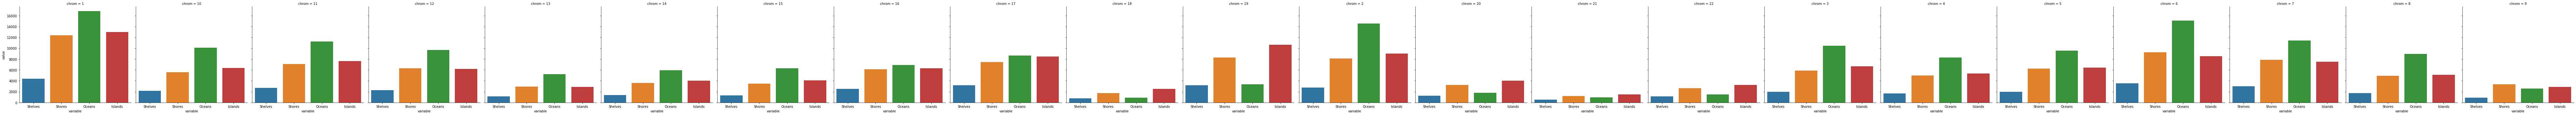

In [90]:
sns.catplot(y="value",x="variable",data=wizuali,col="chrom",kind="bar")

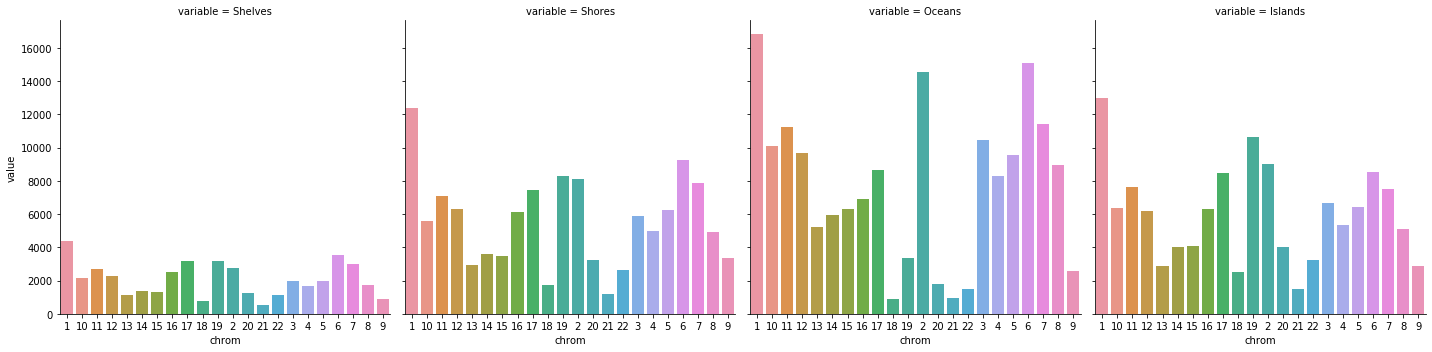

In [103]:
sns.catplot(y="value",x="chrom",data=wizuali,col="variable",kind="bar")

In [214]:
wizuali2=wizuali.groupby("chrom").sum()

wizuali2=wizuali2/wizuali2.sum()

wizuali2=wizuali2.round(3)*100

wizuali2

,value
chrom,
1,9.9
10,5.1
11,6.1
12,5.2
13,2.6
14,3.2
15,3.2
16,4.6
17,5.9


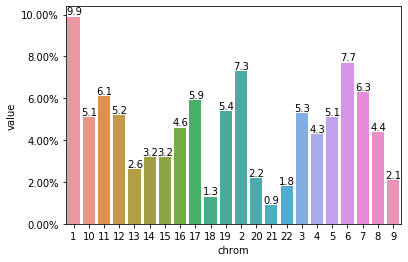

In [210]:
ax=sns.barplot(y="value",x="chrom",data=wizuali2.reset_index())
y_value=['{:,.2f}'.format(x) + '%' for x in ax.get_yticks()]
ax.set_yticklabels(y_value)
for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()-0.1, p.get_height()+0.1))

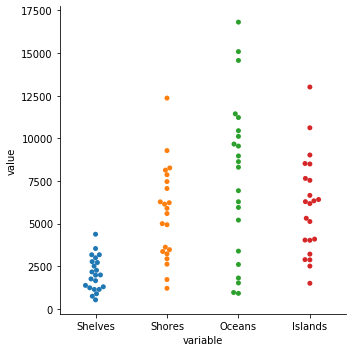

In [113]:
sns.catplot(y="value",x="variable",data=wizuali,kind="swarm")

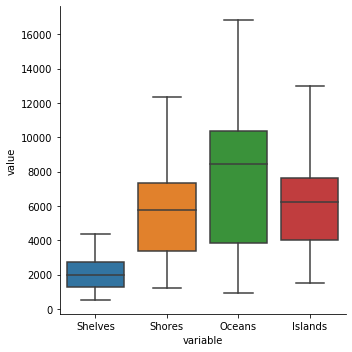

In [124]:
sns.catplot(y="value",x="variable",data=wizuali,kind="box")

In [216]:
wizuali3=wizuali.groupby("variable").sum()

wizuali3=wizuali3/wizuali3.sum()

wizuali3=wizuali3.round(3)*100

wizuali3

,value
variable,
Islands,28.1
Oceans,36.2
Shelves,9.7
Shores,26.1


In [2]:
ax=sns.barplot(y="value",x="variable",data=wizuali3.reset_index())

for p in ax.patches:
    ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.26, p.get_height()+0.2), size='large')

NameError: name 'sns' is not defined

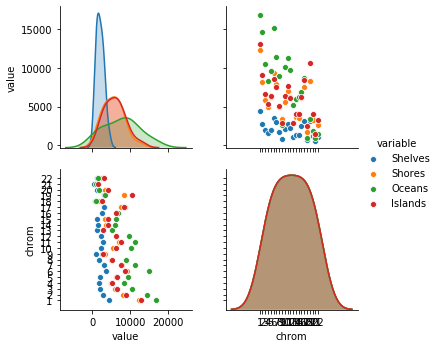

In [245]:
sns.pairplot(data=wizuali,hue="variable")